In [1]:
!pip install yfinance
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 592 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 907 kB 9.2 MB/s 


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from statsmodels.graphics.tsaplots import *
import math, warnings

import scipy.stats as stats
import statsmodels.api as sm
from arch.unitroot import ADF
from statsmodels.tsa import stattools, arima_model

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, TimeDistributed
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/537')

Mounted at /content/gdrive/


In [5]:
warnings.filterwarnings("ignore")

In [7]:
start_date = '2012-12-1'
end_date = '2022-11-30'
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
win_size = 60

# Data

## Data prepare

In [8]:
# Nvidia: NVDA
# Microsoft: MSFT
# Oracle: ORCL
# Meta: META
def get_data(stock_name, start_date, end_date):
  df = yf.download(stock_name, start = start_date, end = end_date)
  return df['Close']

In [9]:
def plot_price(stock_price, stock_name):
  plt.figure(figsize = (12,6))
  plt.plot(stock_price)
  plt.title('Close prices of {}'.format(stock_name))
  plt.xlabel('Date')
  plt.ylabel('price')
  plt.grid()
  return

[*********************100%***********************]  1 of 1 completed


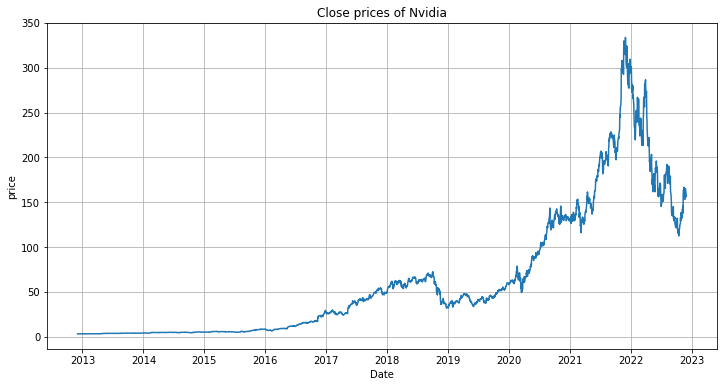

In [10]:
nvda = get_data('NVDA', start_date, end_date)
plot_price(nvda, 'Nvidia')

In [162]:
len(nvda)

2516

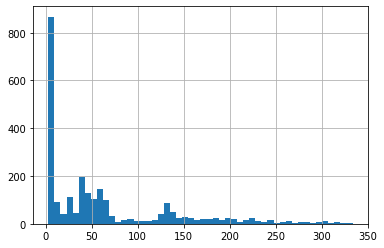

In [163]:
nvda.hist(bins = 50)

In [164]:
nvda.describe()

count    2516.000000
mean       63.290276
std        73.253439
min         2.937500
25%         5.515000
50%        39.337500
75%        88.110001
max       333.760010
Name: Close, dtype: float64

[*********************100%***********************]  1 of 1 completed


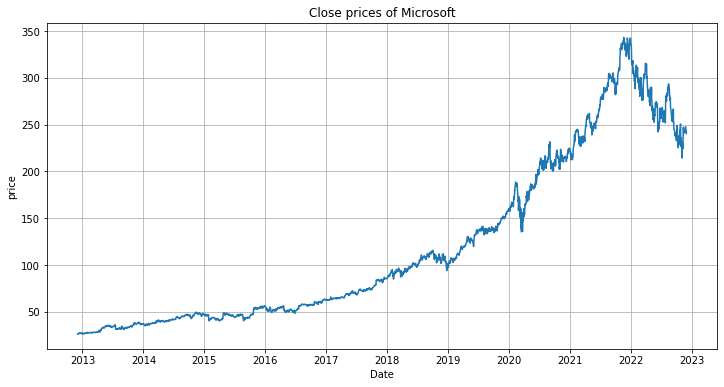

In [165]:
msft = get_data('MSFT', start_date, end_date)
plot_price(msft, 'Microsoft')

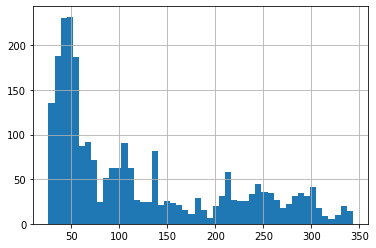

In [166]:
msft.hist(bins = 50)

In [167]:
msft.describe()

count    2516.000000
mean      119.977719
std        89.525689
min        26.370001
25%        46.747500
50%        84.150002
75%       186.855003
max       343.109985
Name: Close, dtype: float64

# ARIMA model

## Data

### stationary test

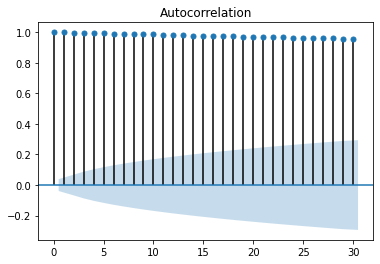

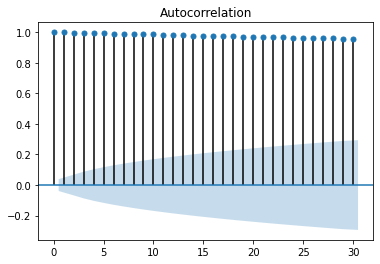

In [91]:
plot_acf(nvda, lags = 30)

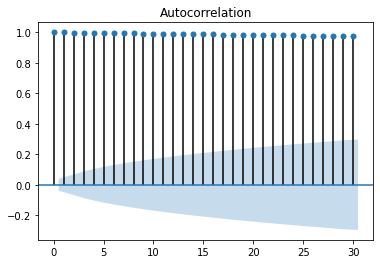

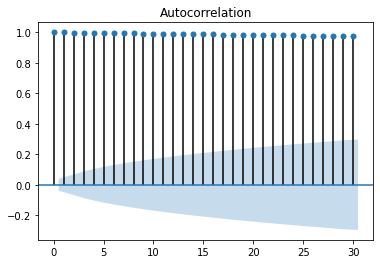

In [168]:
plot_acf(msft, lags = 30)

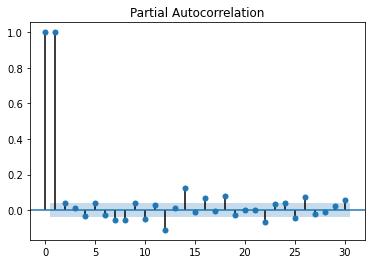

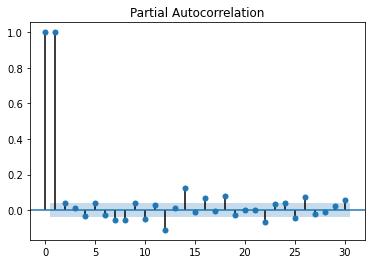

In [92]:
plot_pacf(nvda, lags = 30)

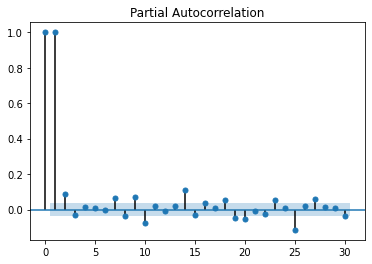

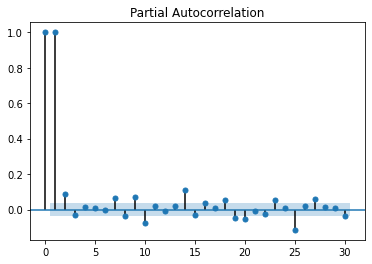

In [170]:
plot_pacf(msft, lags = 30)

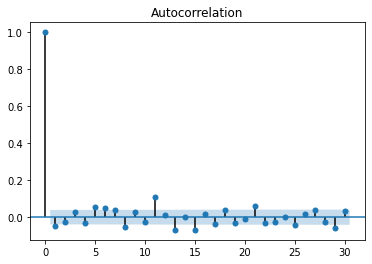

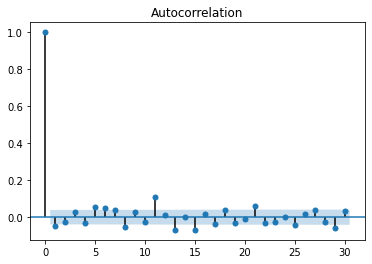

In [100]:
nvda_diff1 = nvda.diff().dropna()
plot_acf(nvda_diff1, lags = 30)

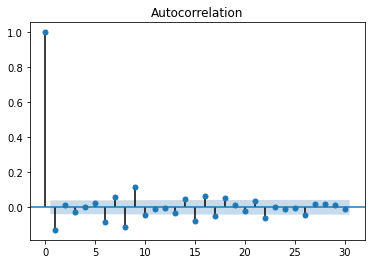

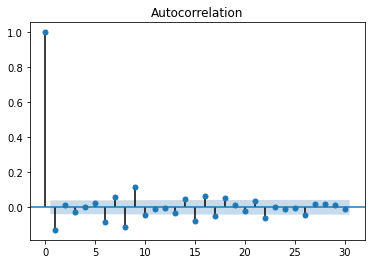

In [171]:
msft_diff1 = msft.diff().dropna()
plot_acf(msft_diff1, lags = 30)

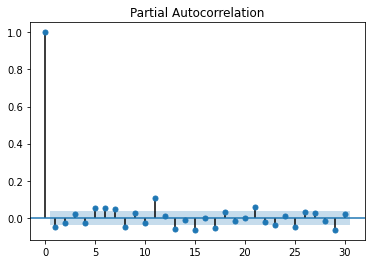

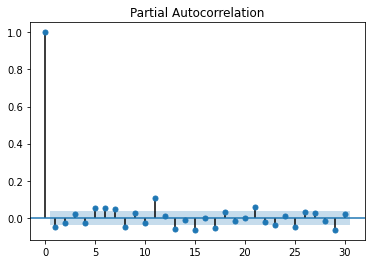

In [96]:
plot_pacf(nvda_diff1, lags = 30)

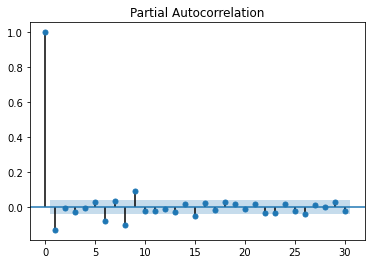

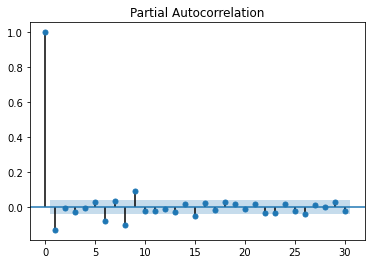

In [172]:
plot_pacf(msft_diff1, lags = 30)

In [95]:
print(ADF(nvda_diff1, max_lags = 20).summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -10.617
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**From the ACF plot and ADF result, we can see that nvda_diff1 is stationary sequence.**

In [173]:
print(ADF(msft_diff1, max_lags = 20).summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -17.132
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### white noise test

In [174]:
LB_nvda = stattools.q_stat(stattools.acf(nvda_diff1)[1:12], len(nvda_diff1))
LB_nvda[1][-1]

9.856548142229429e-11

In [175]:
LB_msft = stattools.q_stat(stattools.acf(msft_diff1)[1:12], len(msft_diff1))
LB_msft[1][-1]

1.0517628620885162e-25

**nvda_diff1 is not white noise sequence.**

### train test split

In [284]:
def data_arima(data):
  n_train = int(len(data) * (train_ratio + val_ratio))
  data_train = data[: n_train]
  data_test = data[n_train: ]
  print('The length of total, training data, test data = {}\n'.format((len(data), len(data_train), len(data_test))))
  print('===========================The result for Unit-Root test:===========================\n')
  print(ADF(data_train, max_lags = 10).summary().as_text())
  return data_train, data_test

In [221]:
# def data_split(data):
#   n_train = int(len(data) * (train_ratio + val_ratio))
#   data_train = data[: n_train]
#   data_test = data[n_train: ]
#   return data_train, data_test

In [276]:
# NVDA
nvda_train, nvda_test = data_arima(nvda_diff1)

The length of total, training data, test data = (2515, 2263, 252)

===========================The result for Unit-Root test:===========================

   Augmented Dickey-Fuller Results   
Test Statistic                -10.820
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [285]:
# MSFT
msft_train, msft_test = data_arima(msft_diff1)

The length of total, training data, test data = (2515, 2263, 252)

===========================The result for Unit-Root test:===========================

   Augmented Dickey-Fuller Results   
Test Statistic                -14.830
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Model

In [246]:
def search_arima(train_set, p_list, q_list):
  aic_bic = []
  base = float('inf')
  best_param = 0
  for p in p_list:
    for q in q_list:
      try:
        model = arima_model.ARIMA(train_set, order = (p, 0, q)).fit()
        aic, bic = model.aic, model.bic
        criterion = (aic + bic) / 2
        if criterion < base:
          base = criterion
          best_param = (p, q)
          best_model = model
        aic_bic.append([(p,q), aic, bic, criterion])
        print('(p,q) = ',(p,q),' (AIC, BIC) = ', (aic, bic))
      except:
        print('{} fails!'.format((p, q)))
  return pd.DataFrame(aic_bic, columns = ['(p,q)','AIC','BIC','AVG of AIC and BIC']), best_param, best_model

In [224]:
p_list = [0, 1, 2, 3, 4, 5]
q_list = [0, 1, 2]

In [277]:
# NVDA
aic_bic, best_param, best_model = search_arima(nvda_train, p_list, q_list)
print('\nThe best parameters for NVDA is {}'.format(best_param))

(p,q) =  (0, 0)  (AIC, BIC) =  (9880.30076626664, 9891.749659557907)
(p,q) =  (0, 1)  (AIC, BIC) =  (9869.396250591215, 9886.569590528115)
(p,q) =  (0, 2)  (AIC, BIC) =  (9864.072155551132, 9886.969942133666)
(p,q) =  (1, 0)  (AIC, BIC) =  (9868.07652150129, 9885.249861438191)
(p,q) =  (1, 1)  (AIC, BIC) =  (9867.932065643818, 9890.829852226352)
(1, 2) fails!
(p,q) =  (2, 0)  (AIC, BIC) =  (9865.313302367587, 9888.211088950122)
(p,q) =  (2, 1)  (AIC, BIC) =  (9842.88582594655, 9871.508059174717)
(p,q) =  (2, 2)  (AIC, BIC) =  (9845.997692870505, 9880.344372744306)
(p,q) =  (3, 0)  (AIC, BIC) =  (9865.193351264139, 9893.815584492306)
(p,q) =  (3, 1)  (AIC, BIC) =  (9860.142862751109, 9894.48954262491)
(p,q) =  (3, 2)  (AIC, BIC) =  (9842.157022026353, 9882.228148545788)
(p,q) =  (4, 0)  (AIC, BIC) =  (9861.627459694246, 9895.974139568047)
(p,q) =  (4, 1)  (AIC, BIC) =  (9858.622666811512, 9898.693793330947)
(p,q) =  (4, 2)  (AIC, BIC) =  (9856.845845965312, 9902.641419130381)
(p,q) =  (

In [278]:
aic_bic

,"(p,q)",AIC,BIC,AVG of AIC and BIC
0,"(0, 0)",9880.300766,9891.749660,9886.025213
1,"(0, 1)",9869.396251,9886.569591,9877.982921
2,"(0, 2)",9864.072156,9886.969942,9875.521049
3,"(1, 0)",9868.076522,9885.249861,9876.663191
4,"(1, 1)",9867.932066,9890.829852,9879.380959
5,"(2, 0)",9865.313302,9888.211089,9876.762196
6,"(2, 1)",9842.885826,9871.508059,9857.196943
7,"(2, 2)",9845.997693,9880.344373,9863.171033
8,"(3, 0)",9865.193351,9893.815584,9879.504468
9,"(3, 1)",9860.142863,9894.489543,9877.316203


In [286]:
# MSFT
aic_bic2, best_param2, best_model2 = search_arima(msft_train, p_list, q_list)
print('\nThe best parameters for MSFT is {}'.format(best_param2))

(p,q) =  (0, 0)  (AIC, BIC) =  (9873.824224156806, 9885.273117448072)
(p,q) =  (0, 1)  (AIC, BIC) =  (9783.02483176298, 9800.19817169988)
(p,q) =  (0, 2)  (AIC, BIC) =  (9775.478614747979, 9798.376401330514)
(p,q) =  (1, 0)  (AIC, BIC) =  (9774.57536092514, 9791.748700862041)
(p,q) =  (1, 1)  (AIC, BIC) =  (9775.310642098208, 9798.208428680742)
(p,q) =  (1, 2)  (AIC, BIC) =  (9785.187145926653, 9813.80937915482)
(p,q) =  (2, 0)  (AIC, BIC) =  (9775.169950890862, 9798.067737473397)
(p,q) =  (2, 1)  (AIC, BIC) =  (9771.231872493172, 9799.854105721339)
(p,q) =  (2, 2)  (AIC, BIC) =  (9733.064335446306, 9767.411015320107)
(p,q) =  (3, 0)  (AIC, BIC) =  (9777.029672356244, 9805.651905584411)
(p,q) =  (3, 1)  (AIC, BIC) =  (9764.376263289578, 9798.722943163379)
(p,q) =  (3, 2)  (AIC, BIC) =  (9716.358414884402, 9756.429541403837)
(p,q) =  (4, 0)  (AIC, BIC) =  (9777.866627250021, 9812.213307123822)
(p,q) =  (4, 1)  (AIC, BIC) =  (9761.581064819831, 9801.652191339266)
(p,q) =  (4, 2)  (AIC, B

In [287]:
aic_bic2

,"(p,q)",AIC,BIC,AVG of AIC and BIC
0,"(0, 0)",9873.824224,9885.273117,9879.548671
1,"(0, 1)",9783.024832,9800.198172,9791.611502
2,"(0, 2)",9775.478615,9798.376401,9786.927508
3,"(1, 0)",9774.575361,9791.748701,9783.162031
4,"(1, 1)",9775.310642,9798.208429,9786.759535
5,"(1, 2)",9785.187146,9813.809379,9799.498263
6,"(2, 0)",9775.169951,9798.067737,9786.618844
7,"(2, 1)",9771.231872,9799.854106,9785.542989
8,"(2, 2)",9733.064335,9767.411015,9750.237675
9,"(3, 0)",9777.029672,9805.651906,9791.340789


## Model diagnosis

In [279]:
print(best_model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2263
Model:                     ARMA(5, 1)   Log Likelihood               -4906.409
Method:                       css-mle   S.D. of innovations              2.115
Date:                Mon, 12 Dec 2022   AIC                           9828.818
Time:                        01:25:43   BIC                           9874.613
Sample:                             0   HQIC                          9845.528
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1510      0.063      2.406      0.016       0.028       0.274
ar.L1.Close     0.7060      0.068     10.393      0.000       0.573       0.839
ar.L2.Close     0.1065      0.027      3.980    

In [288]:
print(best_model2.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2263
Model:                     ARMA(3, 2)   Log Likelihood               -4851.179
Method:                       css-mle   S.D. of innovations              2.064
Date:                Mon, 12 Dec 2022   AIC                           9716.358
Time:                        01:32:42   BIC                           9756.430
Sample:                             0   HQIC                          9730.980
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1367      0.037      3.685      0.000       0.064       0.209
ar.L1.Close    -1.9651      0.046    -42.296      0.000      -2.056      -1.874
ar.L2.Close    -1.2052      0.067    -18.074    

In [280]:
def plot_diagnosticsTight3(model):
  data = model.resid
  fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1,figsize=(5,9))
  
  ax1.hist(data, bins =40,color='m', density = True)  
  mu = data.mean()
  sigma = data.std()
  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
  ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
  ax1.grid()
  ax1.set_title("Hist Resid")
  
  ax2.plot(data)
  ax2.grid()
  ax2.set_title("Resid")
  
  fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
  ax3.grid()
  
  fig = sm.qqplot(data, line='q', ax = ax4)
  ax4.grid()

  plt.tight_layout()
  
  # white noise
  std_resid = data / math.sqrt(model.sigma2)
  LB_resid = stattools.q_stat(stattools.acf(std_resid)[1:13], len(std_resid))
  print('The LB test result = {}\n'.format(LB_resid[1][-1]))

The LB test result = 0.8894055870188464



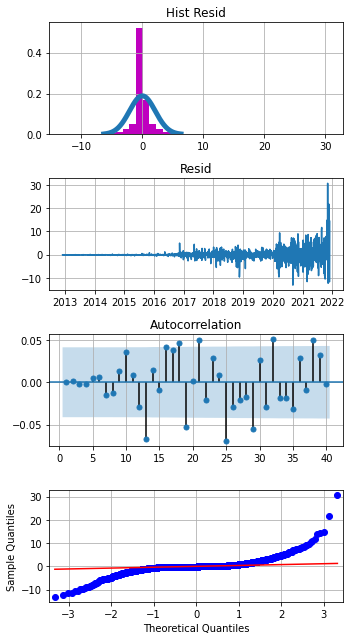

In [281]:
plot_diagnosticsTight3(best_model)

The LB test result = 0.22196870679367844



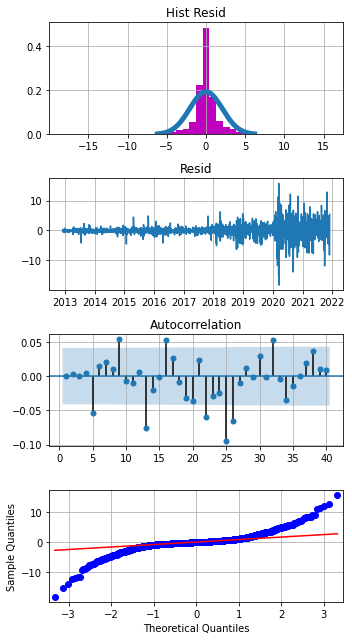

In [289]:
plot_diagnosticsTight3(best_model2)

**P-value is greater than 0.05, which means the residual is a white-noise sequence. Our model greatly fitted the data.**

## Predict and evaluation

In [282]:
def evaluation_arima(model, data, test):
  # predict
  diff_pred = model.forecast(len(test))[0]
  base = data[-len(test)-1]
  test_pred = []
  for i in range(len(diff_pred)):
    d = diff_pred[i]
    if i == 0:
      price = d + base
    else:
      price += d
    test_pred.append(price)
  
  # train = pd.DataFrame(data[:-len(test)], columns = ['true'])
  test_true = data[-len(test): ]
  test_pred = np.array(test_pred)
  

  test = pd.DataFrame()
  test['true'] = test_true
  test['pred'] = test_pred
  test = test.set_index(np.array([i for i in range(len(data)-len(test),len(data))]))
  
  plt.figure(figsize=(9,6))
  # plt.plot(train['true'], linewidth = 2)
  plt.plot(test[['true', 'pred']], linewidth = 2)
  plt.legend(['True Price(Test)','Predict Price(Test)'],loc = 'upper left')
  plt.show()

  
  test_rmse = metrics.mean_squared_error(test_true, test_pred) ** 0.5
  print('RMSE for test set = {}'.format(test_rmse))

  test_mae = metrics.mean_absolute_error(test_true, test_pred)
  print('MAE for unscaled test set = {}'.format(test_mae))
  return 

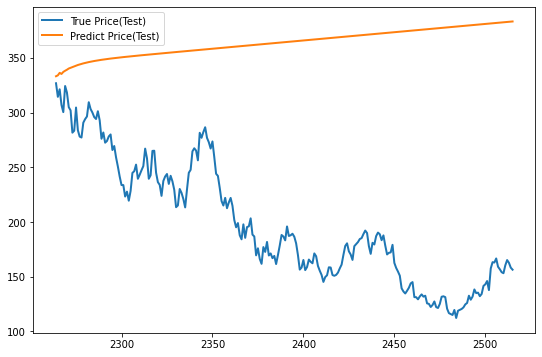

RMSE for test set = 178.6783080770759
MAE for unscaled test set = 165.57523458272436


In [283]:
evaluation_arima(best_model, nvda, nvda_test)

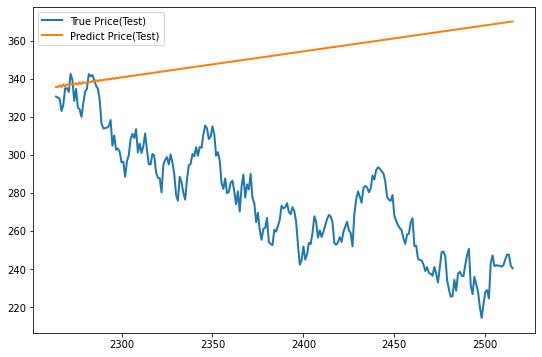

RMSE for test set = 85.8177255436598
MAE for unscaled test set = 76.34210732077653


In [290]:
evaluation_arima(best_model2, msft, msft_test)

# GARCH

## ARCH

In [ ]:
LB_arch = stattools.q_stat(stattools.acf(nvda ** 2)[1:13], len(nvda))

In [ ]:
LB_arch[1][-1]

0.0

In [ ]:
LB_arch

(array([ 1248.44553295,  2487.67037911,  3719.42961057,  4941.83807257,
         6156.43495671,  7361.2319596 ,  8553.4840305 ,  9733.83277789,
        10903.2658229 , 12061.7839329 , 13210.54641496, 14346.56427684]),
 array([1.80677939e-273, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

# LSTM

## model building and training

In [13]:
def data_split_lstm(data):
  n_train = int(len(data) * train_ratio)
  n_val = int(len(data) * val_ratio)
  return data[: n_train], data[n_train: n_train + n_val], data[n_train + n_val:]

In [14]:
def win(data, win_size):
  x = []
  y = data[win_size:].reshape(1, -1)[0]
  for i in range(win_size, len(data)):
      x.append(data[i-win_size:i, 0])
  x = np.array(x).reshape(len(x), len(x[0]), 1)
  return x, y

In [15]:
def load_data(train_data, val_data, test_data, win_size):
  x_train, y_train = win(train_data, win_size)
  x_val, y_val = win(val_data, win_size)
  x_test, y_test = win(test_data, win_size)
  return x_train, y_train, x_val, y_val, x_test, y_test

In [82]:
def build_model(params, input_shape, n_layer, optimizer = False):
  '''
  params: parameters of LSTM model
  input_shape: the shape of input data
  optimizer: whether use He weight initializers or not
  '''
  model = Sequential()

  if optimizer: 
    initializer = tf.keras.initializers.HeNormal()
    first_layer = LSTM(units=params["lstm_units"], kernel_initializer=initializer, return_sequences = True, input_shape=(input_shape, 1))
  else:
    first_layer = LSTM(units=params["lstm_units"], return_sequences = True, input_shape=(input_shape, 1))
  
  for i in range(n_layer):
    if i == 0 and i == n_layer - 1:
      model.add(LSTM(units=params["lstm_units"], input_shape=(input_shape, 1)))
      model.add(Dropout(rate=params["dropout"]))
    elif i == 0:
      model.add(first_layer)
      model.add(Dropout(rate=params["dropout"]))
    elif i == n_layer - 1:
      model.add(LSTM(units=params["lstm_units"]))
    else:
      model.add(LSTM(units=params["lstm_units"], return_sequences = True))
      model.add(Dropout(rate=params["dropout"]))
  model.add(Dense(1))
  model.compile(loss=params["loss"],
              	optimizer=params["optimizer"],
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
  return model

In [33]:
def plot_loss(model_history):
  '''
  plot both loss change on training set and validation set during training
  '''
  train_loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  plt.plot(train_loss, label = 'Training Loss')
  plt.plot(val_loss, label = 'Validation Loss')
  plt.legend(loc = 'upper right')
  plt.grid()
  return

In [161]:
# NVDA
n_train = int(len(nvda) * train_ratio)
n_val = int(len(nvda) * val_ratio)

scaler = MinMaxScaler(feature_range=(0,1))
nvda_scaled = scaler.fit_transform(nvda.values.reshape(-1, 1))

nvda_ = np.array(nvda).reshape(-1, 1)
nvda_train_unscaled, nvda_val_unscaled, nvda_test_unscaled = data_split_lstm(nvda_)
x_train_unscaled, y_train_unscaled, x_val_unscaled, y_val_unscaled, x_test_unscaled, y_test_unscaled = \
                load_data(nvda_train_unscaled, nvda_val_unscaled, nvda_test_unscaled, win_size)

nvda_train, nvda_val, nvda_test = data_split_lstm(nvda_scaled)
x_train, y_train, x_val, y_val, x_test, y_test = load_data(nvda_train, nvda_val, nvda_test, win_size)
print('The length of train set, validation set, test set: {}'.format((len(y_train), len(y_val), len(y_test))))

The length of train set, validation set, test set: (1701, 443, 192)


In [293]:
# MSFT
n_train = int(len(msft) * train_ratio)
n_val = int(len(msft) * val_ratio)

scaler = MinMaxScaler(feature_range=(0,1))
msft_scaled = scaler.fit_transform(msft.values.reshape(-1, 1))

msft_ = np.array(msft).reshape(-1, 1)
msft_train_unscaled, msft_val_unscaled, msft_test_unscaled = data_split_lstm(msft_)
x_train_unscaled, y_train_unscaled, x_val_unscaled, y_val_unscaled, x_test_unscaled, y_test_unscaled = \
                load_data(msft_train_unscaled, msft_val_unscaled, msft_test_unscaled, win_size)

msft_train, msft_val, msft_test = data_split_lstm(msft_scaled)
x_train, y_train, x_val, y_val, x_test, y_test = load_data(msft_train, msft_val, msft_test, win_size)
print('The length of train set, validation set, test set: {}'.format((len(y_train), len(y_val), len(y_test))))

The length of train set, validation set, test set: (1701, 443, 192)


In [311]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 50,
	"epochs": 200,
	"batch_size": 256,
	"es_patience" : 10
}
# early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',mode='min',patience=params["es_patience"])

### nvda

In [84]:
n_layer = 1
lstm = build_model(params, x_train.shape[1], n_layer)

In [86]:
# train model
lstm_model = lstm.fit(
	x_train,
	y_train,
	validation_data=(x_val, y_val),
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=0,
	callbacks=es_callback
)

In [87]:
# save model
lstm.save('/content/gdrive/My Drive/537/project/NVDA_model/lstm_50_1_10.keras')

In [ ]:
# # upload model
# lstm = tf.keras.models.load_model('/content/gdrive/My Drive/537/project/NVDA_model/lstm_3_10.keras')

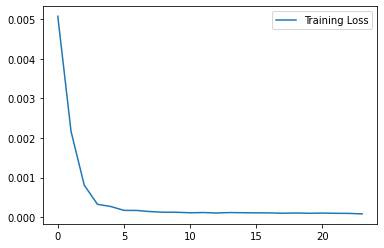

In [89]:
# plot loss change on training set
plt.plot(lstm_model.history['loss'], label = 'Training Loss')
plt.legend(loc = 'upper right')

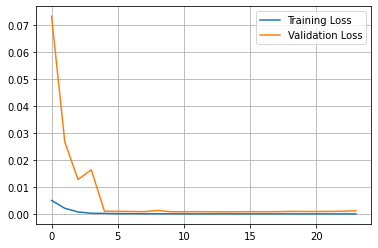

In [90]:
plot_loss(lstm_model)

### msft

In [327]:
n_layer = 1
lstm2 = build_model(params, x_train.shape[1], n_layer)

In [328]:
# train model
lstm2_model = lstm2.fit(
	x_train,
	y_train,
	validation_data=(x_val, y_val),
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=0,
	callbacks=es_callback
)

In [325]:
# save model
lstm2.save('/content/gdrive/My Drive/537/project/MSFT_model/lstm_50_1_10.keras')

In [ ]:
# # upload model
# lstm = tf.keras.models.load_model('/content/gdrive/My Drive/537/project/MSFT_model/lstm_3_10.keras')

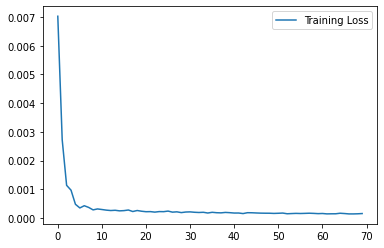

In [317]:
# plot loss change on training set
plt.plot(lstm2_model.history['loss'], label = 'Training Loss')
plt.legend(loc = 'upper right')

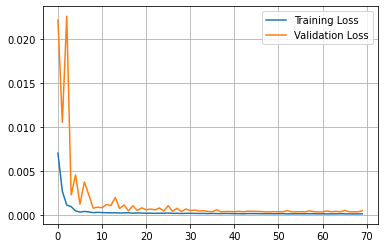

In [318]:
plot_loss(lstm2_model)

## predict and evaluation

In [40]:
def evaluation(lstm):
  # predict
  train_pred = lstm.predict(x_train)
  val_pred = lstm.predict(x_val)
  test_pred = lstm.predict(x_test)

  # scaled data error
  scaled_val_rmse = metrics.mean_squared_error(val_pred, y_val) ** 0.5
  scaled_test_rmse = metrics.mean_squared_error(test_pred, y_test) ** 0.5
  print('RMSE for scaled validation set = {}'.format(scaled_val_rmse))
  print('RMSE for scaled test set = {}'.format(scaled_test_rmse))

  train_pred_unscaled = scaler.inverse_transform(train_pred)
  val_pred_unscaled = scaler.inverse_transform(val_pred)
  test_pred_unscaled = scaler.inverse_transform(test_pred)
  
  train = pd.DataFrame()
  train['true'] = y_train_unscaled
  train['pred'] = train_pred_unscaled

  val = pd.DataFrame()
  val['true'] = y_val_unscaled
  val['pred'] = val_pred_unscaled
  val = val.set_index(np.array([i for i in range(n_train + win_size, n_train + n_val)]))  

  test = pd.DataFrame()
  test['true'] = y_test_unscaled
  test['pred'] = test_pred_unscaled
  test = test.set_index(np.array([i for i in range(n_train + n_val + win_size, n_train+n_val+win_size+len(test_pred))]))
  
  plt.figure(figsize=(15,10))
  plt.plot(train[['true', 'pred']], linewidth = 2)
  plt.plot(val[['true', 'pred']], linewidth = 2)
  plt.plot(test[['true', 'pred']], linewidth = 2)
  plt.legend(['True Price(Train)','Predict Price(Train)','True Price(Validation)',\
        'Predict Price(Validation)','True Price(Test)','Predict Price(Test)'],loc = 'upper left')

  val_rmse = metrics.mean_squared_error(val_pred_unscaled, y_val_unscaled) ** 0.5
  test_rmse = metrics.mean_squared_error(test_pred_unscaled, y_test_unscaled) ** 0.5
  print('RMSE for unscaled validation set = {}'.format(val_rmse))
  print('RMSE for unscaled test set = {}'.format(test_rmse))

  val_mae = metrics.mean_absolute_error(val_pred_unscaled, y_val_unscaled)
  test_mae = metrics.mean_absolute_error(test_pred_unscaled, y_test_unscaled)
  print('MAE for unscaled validation set = {}'.format(val_mae))
  print('MAE for unscaled test set = {}'.format(test_mae))
  return 

In [291]:
def plot_test(lstm):
  # predict
  test_pred = lstm.predict(x_test)
  test_pred_unscaled = scaler.inverse_transform(test_pred)

  test = pd.DataFrame()
  test['true'] = y_test_unscaled
  test['pred'] = test_pred_unscaled
  test = test.set_index(np.array([i for i in range(n_train + n_val + win_size, n_train+n_val+win_size+len(test_pred))]))
  
  plt.figure(figsize=(9,6))
  plt.plot(test[['true', 'pred']], linewidth = 2)
  plt.legend(['True Price(Test)','Predict Price(Test)'],loc = 'upper right')
  return 

### nvda

6/6 [==============================] - 0s 8ms/step
RMSE for scaled validation set = 0.035076160907475104
RMSE for scaled test set = 0.04663937733739223
RMSE for unscaled validation set = 11.60398516833379
RMSE for unscaled test set = 15.429354751471976
MAE for unscaled validation set = 7.9037511580146464
MAE for unscaled test set = 12.112732370694479


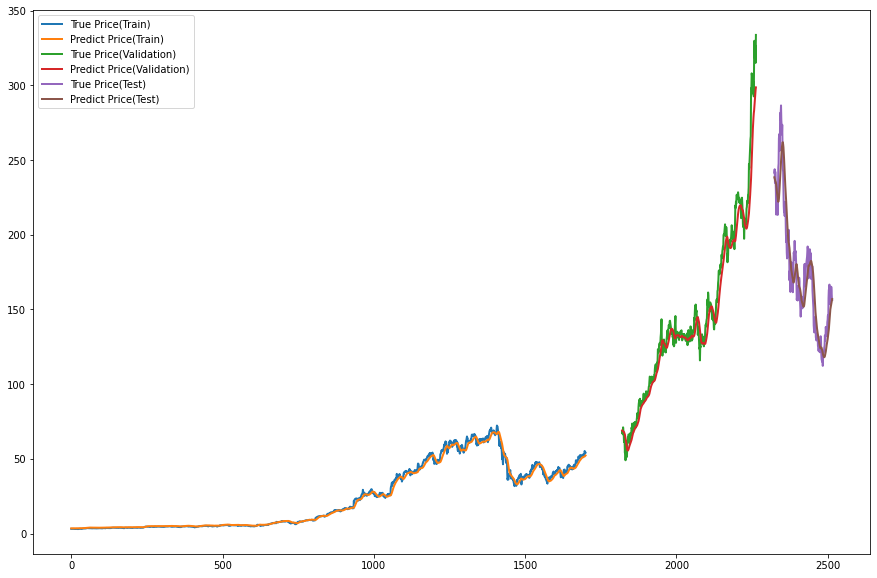

In [88]:
evaluation(lstm)

6/6 [==============================] - 0s 7ms/step


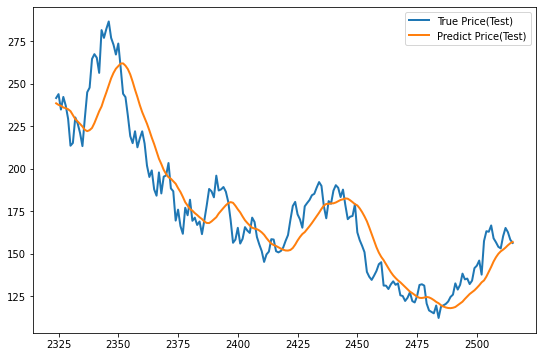

In [292]:
plot_test(lstm)

### msft

6/6 [==============================] - 0s 9ms/step
RMSE for scaled validation set = 0.022035881178168848
RMSE for scaled test set = 0.03363992723264076
RMSE for unscaled validation set = 6.979644004157673
RMSE for unscaled test set = 10.655108993145952
MAE for unscaled validation set = 5.357085871642653
MAE for unscaled test set = 8.735244909922281


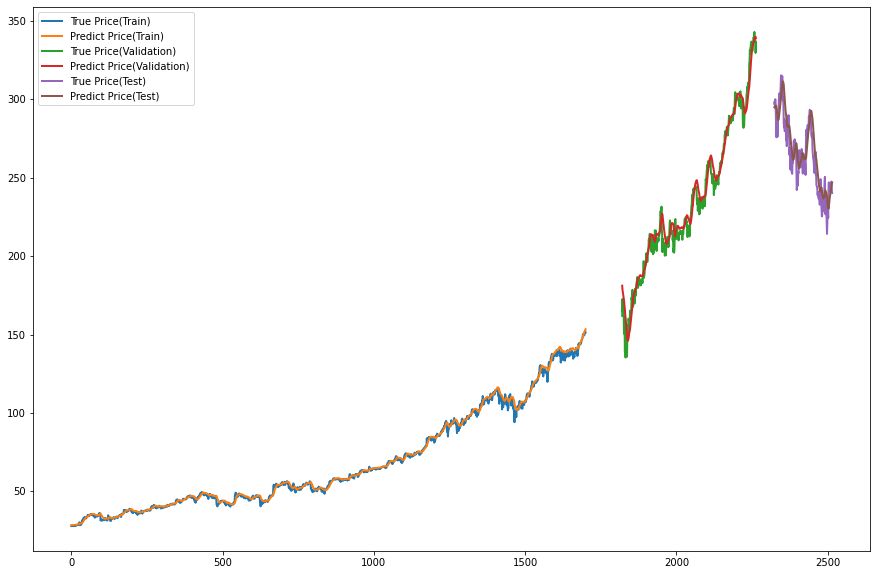

In [329]:
evaluation(lstm2)

6/6 [==============================] - 0s 8ms/step


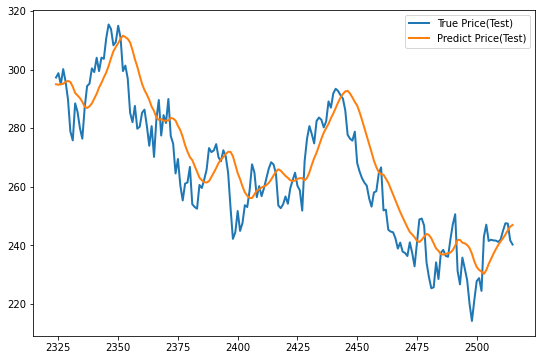

In [330]:
plot_test(lstm2)